<h2><center>Implementation on data</center></h2>

Data selection: 10 year weekly data from 02 Nov 2007 - 02 Nov 2017. Top 20 constituents of S&P 500

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

## Multiple stock formulation

Import data

Read one stock first (Apple)

In [7]:
N = 20
data_path = './data/'
#gspc = pd.read_csv(data_path + "gspc.csv", header=0, index_col=0, squeeze=True)
aapl = pd.read_csv(data_path + "aapl.csv", header=0, index_col=0, squeeze=True)
price_aapl = aapl["Close"].values[:-1]
rtn_aapl = (price_aapl[1:]-price_aapl[:-1])/price_aapl[:-1]
#print(len(price_aapl))
#print(len(rtn_aapl))
X = np.zeros((N, len(rtn_aapl)))
#print(X.shape)

In [11]:
rtn = np.zeros((N, len(rtn_aapl)))
price = np.zeros((N, len(rtn_aapl)+1))
i = 0
for file in os.listdir(data_path):
    if file[-3:] == "csv" and file != "GSPC.csv":
        data = pd.read_csv(data_path + file, header=0, index_col=0, squeeze=True)
        # Price
        this_price = data["Close"].values[:-1]
        price[i] = this_price
        
        # Return
        this_rtn = (this_price[1:]-this_price[:-1])/this_price[:-1]
        # abnormal data check
        if len(this_rtn) != 522:
            print(file, ', ', len(this_rtn))
        else:
            rtn[i] = this_rtn
        i += 1
        

Define constants

In [12]:
num_rtn = rtn.shape[1]
num_price = num_rtn+1

In [13]:
# r-f rate--2.5%
r = 0.025

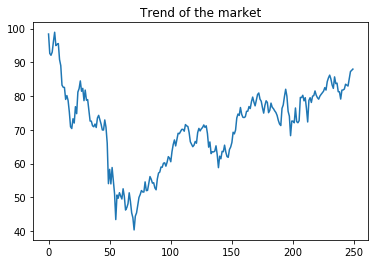

In [14]:
# See a general trend of stock
plt.title("Trend of the market")
plt.plot(np.mean(price,axis = 0)[:250])
plt.savefig('trend.png')

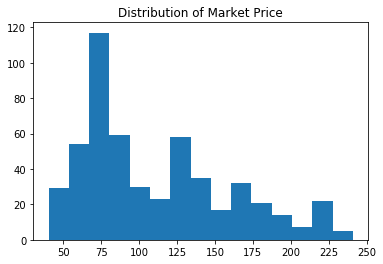

In [15]:
plt.title("Distribution of Market Price")
plt.hist(np.mean(price,axis = 0),bins=15)
#plt.savefig('pricedist.png')

## Static Markowitz implementation

Use the moving window mean of 26 weeks (0.5 year)

In [16]:
def static(wealth_init = 50,target_rtn = 0.15):
    num_stock = 0
    bank_account = -wealth_init
    stock_account = wealth_init
    bank_hist = np.zeros(num_price)
    stock_hist = np.zeros(num_price)
    omega_hist = np.zeros((num_price,price.shape[0]))
    

    for i in range(26, num_price):
        # compute the mean and cov
        rtn_hist = rtn[:, i-26:i]
        mu = np.mean(rtn_hist, axis=1)
        cov = np.cov(rtn_hist)
        
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += sum(num_stock * (price_today - price_ytd))
        
        # Do as strategy
        # omega is the proportion of total investment
        a = sum((sum(cov)))
        b = sum(np.dot(cov,mu))
        c = np.dot(mu, np.dot(cov,mu))
        inverse = np.linalg.inv(cov)
        
        omega = (c - b*target_rtn)/(a*c - b*b) * sum(inverse) + \
            (a*target_rtn - b)/(a*c - b*b) * np.dot(inverse, mu)
        omega = omega / sum(omega) # Normalise
        theta = omega * stock_account
        
        num_stock = theta / price_today
        
        
        bank_account -= (np.sum(theta) - stock_account)
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account
        omega_hist[i] = omega

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)
        
    stock_hist = stock_hist[26:]
    bank_hist = bank_hist[26:]
    wealth = stock_account + bank_account
    print("Final wealth is: ", wealth)
    return (wealth, stock_account, bank_account, stock_hist, bank_hist,omega_hist)
        

Final wealth is:  -109.8944342171431


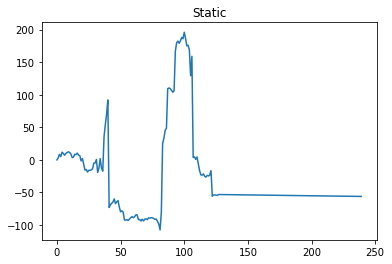

In [17]:
wealth_init = 50
wealth, stock_account, bank_account, \
stock_hist_static, bank_hist_static, omega_hist = static(wealth_init = wealth_init)
plt.title("Static")
plt.plot((stock_hist_static+bank_hist_static)[:240])
#plt.savefig('static.png')

Final wealth is:  -66.52418485555044
Final wealth is:  -109.89443403631294
Final wealth is:  -139.67678078366174


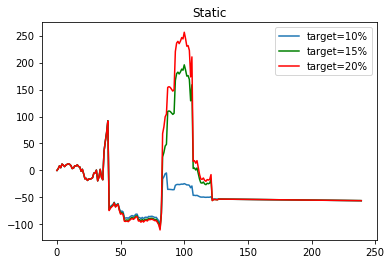

In [18]:
stock_hist_10, bank_hist_10= static(target_rtn=0.1)[3:5]
stock_hist_15, bank_hist_15= static(target_rtn=0.15)[3:5]
stock_hist_20, bank_hist_20= static(target_rtn=0.20)[3:5]
plt.title("Static")
plt.plot((stock_hist_10+bank_hist_10)[:240], label = 'target=10%')
plt.plot((stock_hist_15+bank_hist_15)[:240], 'g', label = 'target=15%')
plt.plot((stock_hist_20+bank_hist_20)[:240], 'r', label = 'target=20%')
plt.legend()
#plt.savefig('static.png')
plt.show()

In [50]:
def allconst(gamma = 10):
    num_stock = 0
    bank_account = 0
    stock_account = 0
    bank_hist = np.zeros(num_price)
    stock_hist = np.zeros(num_price)

    for i in range(26, num_price):
        # compute the mean and cov
        rtn_hist = rtn[:, i-26:i]
        mu = np.mean(rtn_hist, axis=1)
        cov = np.cov(rtn_hist)
        
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += sum(num_stock * (price_today - price_ytd))

        # Do as strategy
        # amount of money invested
        inverse = np.linalg.inv(np.dot(cov.T, cov))
        theta = np.dot(inverse, (mu - r) / gamma * np.exp(-r * (10 - i/52))) # A vector
        num_stock = theta / price_today
        
        
        bank_account -= (np.sum(theta) - stock_account)
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)

    stock_hist = stock_hist[26:]
    bank_hist = bank_hist[26:]
    wealth = stock_account + bank_account
    print("Final wealth is: ", wealth)
    return wealth, stock_account, bank_account, stock_hist, bank_hist

Based on the implementation, gamma only serves as a scale factor. Hence we just set it to be number that makes the strategy comparable 

In [51]:
gamma = 10000000

Final wealth is:  -1995.794237016958


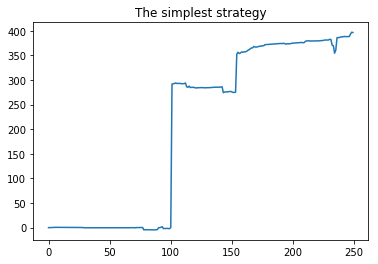

In [52]:
wealth, stock_account, bank_account, stock_hist, bank_hist = allconst(gamma = gamma)
plt.title("The simplest strategy")
plt.plot((stock_hist + bank_hist)[:250])

See the CEV case

In [26]:
def CEV(gamma = 10, alpha = 1):
    num_stock = 0
    bank_account = 0
    stock_account = 0
    bank_hist = np.zeros(num_price)
    stock_hist = np.zeros(num_price)

    for i in range(26, num_price):
        # compute the mean and cov
        rtn_hist = rtn[:, i-26:i]
        mu = np.mean(rtn_hist, axis=1)
        cov = np.cov(rtn_hist)
        
        # PnL summary
        price_today = price[:, i]
        price_ytd = price[:, i-1]
        stock_account += sum(num_stock * (price_today - price_ytd))

        # Do as strategy
        # amount of money invested
        inverse1 = np.linalg.inv(cov)
        inverse2 = np.linalg.inv(np.dot(cov.T, cov))
        sharp1 = np.dot(inverse2, (mu - r) / price_today ** alpha)
        sharp2 = np.dot(inverse2, (mu - r)**2 / price_today**alpha)
        exp = np.exp(-r * (10 - i/52))
        theta =  1/gamma * sharp1 * exp  \
                - 1/gamma*(sharp2)* ((np.exp(-alpha * r * (10 - i/52)) -1 )/r) * exp
        num_stock = theta / price_today
        
        bank_account -= (np.sum(theta) - stock_account)
        stock_account = np.sum(theta)

        # Record history
        bank_hist[i] = bank_account
        stock_hist[i] = stock_account

        # Earn risk free rate
        bank_account *= np.exp(r * 1/52)

    stock_hist = stock_hist[26:]
    bank_hist = bank_hist[26:]
    wealth = stock_account + bank_account
    #print("Final wealth is: ", wealth)
    return wealth, stock_account, bank_account, stock_hist, bank_hist

In [37]:
gamma = 1000000000
alpha = -0.05
wealth, stock_account, bank_account, stock_hist_CEV, bank_hist_CEV = CEV(gamma = gamma, alpha = alpha)
# plt.title("Strategy assuming CEV process, gamma = " + str(gamma)+ ", alpha = " + str(alpha))
# plt.plot(stock_hist_CEV + bank_hist_CEV)

alpha_1 = 0.05
wealth_1, stock_account_1, bank_account_1, stock_hist_CEV_1, bank_hist_CEV_1 = CEV(gamma = gamma, alpha = alpha_1)

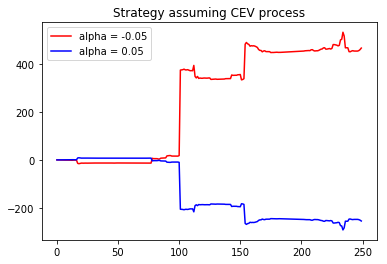

In [38]:
plt.title("Strategy assuming CEV process")
plt.plot((stock_hist_CEV + bank_hist_CEV)[:250], "r", label = "alpha = "+str(alpha))
plt.legend()
plt.plot((stock_hist_CEV_1 + bank_hist_CEV_1)[:250], "b", label = "alpha = "+str(alpha_1))
plt.legend()
#plt.savefig('CEVcompare_1.png')
plt.show()

In [35]:
N = 10
wealth_250 = np.zeros(5*N+1)
alpha_250 = np.zeros(5*N+1)
for i in range(-N, 4*N+1):
    alpha = i / 100
    alpha_250[i+N] = alpha
    wealth, stock_account, bank_account, stock_hist_CEV, bank_hist_CEV = CEV(gamma = gamma, alpha = alpha)
    wealth_250[i+N] = (stock_hist_CEV + bank_hist_CEV)[250]


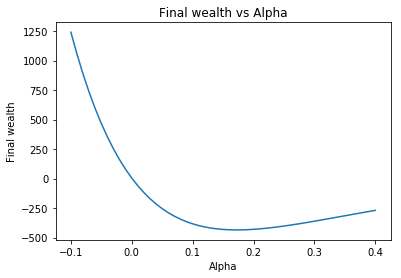

In [36]:
plt.title("Final wealth vs Alpha")
plt.xlabel('Alpha')
plt.ylabel('Final wealth')
plt.plot(alpha_250, wealth_250)
#plt.savefig('wealth.png')
plt.show()

### Compare CEV vs Static strategy

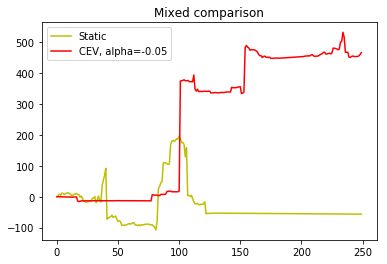

In [53]:
plt.title("Mixed comparison")
plt.plot((stock_hist_static+bank_hist_static)[:250],"y",label = 'Static')
plt.plot((stock_hist_CEV + bank_hist_CEV)[:250], "r", label = "CEV, alpha=" +str(alpha))
plt.legend()
#plt.savefig('realmixed.png')
plt.show()


Theoritical portfolio gain: -ve alpha > simple > +ve alpha